# OCR Project

# part 1: Using CNN

In [1]:
import sys
import os
import numpy as np
import cv2
import difflib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import logging
import tarfile
from skimage.morphology import (erosion, dilation, closing, opening)

# Download dataset

In [2]:
# Step 1: Download the dataset
!wget https://www.orand.cl/orand_car/ORAND-CAR-2014.tar.gz

# Step 2: Create a directory to extract the dataset
os.makedirs("ORAND-CAR-2014", exist_ok=True)

# Step 3: Extract the dataset
with tarfile.open("ORAND-CAR-2014.tar.gz", "r:gz") as tar:
    tar.extractall(path="ORAND-CAR-2014")

# Verify the extraction
print("Files in ORAND-CAR-2014 directory:")
print(os.listdir("ORAND-CAR-2014"))

--2024-09-15 19:38:37--  https://www.orand.cl/orand_car/ORAND-CAR-2014.tar.gz
Resolving www.orand.cl (www.orand.cl)... 162.241.225.60
Connecting to www.orand.cl (www.orand.cl)|162.241.225.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203530245 (194M) [application/x-gzip]
Saving to: ‘ORAND-CAR-2014.tar.gz’

ORAND-CAR-2014.tar. 100%[===================>] 194.10M   108MB/s    in 1.8s    

2024-09-15 19:38:39 (108 MB/s) - ‘ORAND-CAR-2014.tar.gz’ saved [203530245/203530245]

Files in ORAND-CAR-2014 directory:
['ORAND-CAR-2014']


# preprocessing dataset
Function to preprocess image (convert to grayscale and apply binary thresholding)

In [3]:
# element = np.array([[0, 0, 0, 0],
#                     [0, 1, 1, 0],
#                     [0, 1, 1, 0],
#                     [0, 0, 0, 0]], np.uint8)

element4 = np.array([[0, 0, 0, 0],
                     [0, 1, 1, 0],
                     [0, 1, 1, 0],
                     [0, 0, 0, 0]])

# element = np.array([[0, 0, 0, 0, 0],
#                     [0, 1, 1, 1, 0],
#                     [0, 1, 1, 1, 0],
#                     [0, 1, 1, 1, 0],
#                     [0, 0, 0, 0, 0]], np.uint8)

element5 = np.array([[0, 0, 0, 0, 0],
                     [0, 0, 1, 0, 0],
                     [0, 1, 1, 1, 0],
                     [0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 0]])


def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _,binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # binary_img = opening(binary_img, element5)
    # binary_img = erosion(binary_img, element4)
    # binary_img = dilation(binary_img, element2)
    # binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_HITMISS, element)
    return img, binary_img

### Displaying the input images and binary images


In [4]:
def display_image(img, binary_img, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original {title}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(binary_img, cmap='gray')
    plt.title(f"Binary {title}")
    plt.axis('off')

    plt.show()

# Function to find and draw contours

In [6]:
def segment_characters(binary_img, max_width=10, max_height=10):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        if w > max_width and h > max_height:
            filtered_contours.append(contour)

    filtered_contours = sorted(filtered_contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    return filtered_contours

# Function to display contours

In [7]:
def display_contours(img, contours, title):
    img_with_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(img_with_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure(figsize=(10, 5))
    plt.imshow(img_with_contours)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Samples of segmented charactests

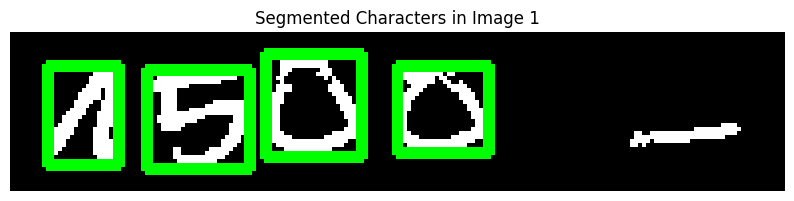

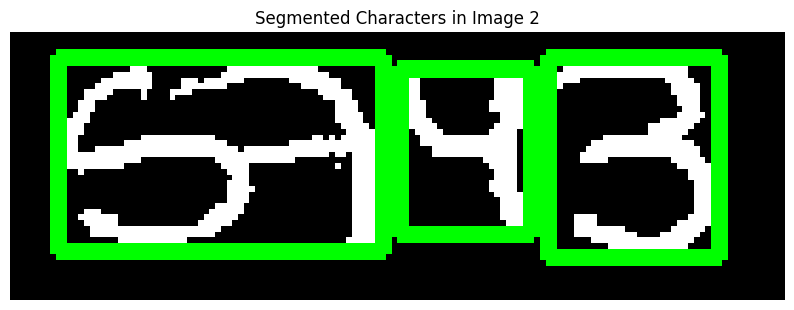

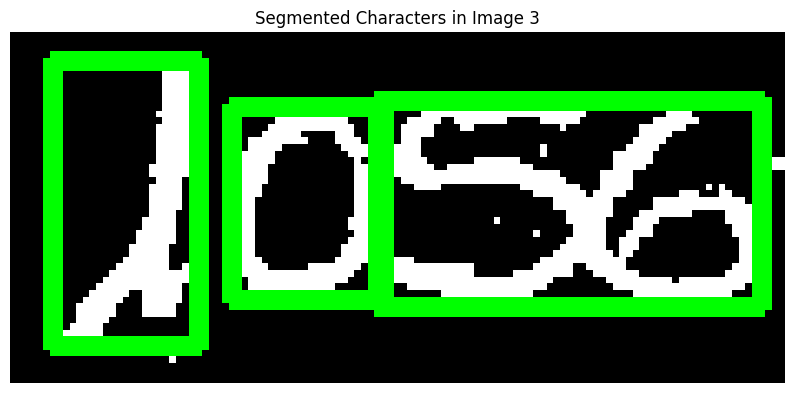

In [8]:
image_paths = ['ORAND-CAR-2014/ORAND-CAR-2014/CAR-A/a_test_images/a_car_007000.png',
               "ORAND-CAR-2014/ORAND-CAR-2014/CAR-A/a_test_images/a_car_007001.png",
               "ORAND-CAR-2014/ORAND-CAR-2014/CAR-A/a_test_images/a_car_007002.png"]

# image_paths = ['ORAND-CAR-2014/ORAND-CAR-2014/CAR-A/a_train_images/a_car_000155.png',
#                "ORAND-CAR-2014/ORAND-CAR-2014/CAR-A/a_train_images/a_car_000156.png",
#                "ORAND-CAR-2014/ORAND-CAR-2014/CAR-A/a_train_images/a_car_000157.png"]
for i, image_path in enumerate(image_paths):
    original, binary = preprocess_image(image_path)
    # display_image(original, binary, Image {i + 1})
    contours = segment_characters(binary)
    display_contours(binary, contours, f"Segmented Characters in Image {i + 1}")



# Training a MNIST model

In [11]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Build a simple CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=32)
model.save('mnist_cnn_model.h5')

Epoch 1/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1264 - accuracy: 0.9609 - val_loss: 0.0552 - val_accuracy: 0.9808
Epoch 2/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0454 - accuracy: 0.9858 - val_loss: 0.0367 - val_accuracy: 0.9875
Epoch 3/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0300 - accuracy: 0.9907 - val_loss: 0.0303 - val_accuracy: 0.9895
Epoch 4/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0213 - accuracy: 0.9930 - val_loss: 0.0343 - val_accuracy: 0.9894
Epoch 5/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0160 - accuracy: 0.9950 - val_loss: 0.0290 - val_accuracy: 0.9910


# preprocess character image for prediction

In [9]:
def preprocess_char_img(char_img):
    char_img = cv2.resize(char_img, (28, 28), interpolation=cv2.INTER_AREA)
    char_img = char_img.astype('float32') / 255.0
    char_img = np.expand_dims(char_img, axis=-1)
    char_img = np.expand_dims(char_img, axis=0)
    return char_img

# Function to recognize characters

In [10]:
def recognize_characters(model, binary_img, contours):
    recognized_digits = ""
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        char_img = binary_img[y:y + h, x:x + w]
        char_img = preprocess_char_img(char_img)
        prediction = model.predict(char_img)
        recognized_digit = np.argmax(prediction)
        recognized_digits = recognized_digits + str(recognized_digit)
    return recognized_digits

# Testing MNIST model on ORAND-CAR-2014 CAR-A test dataset

In [11]:
model = load_model('mnist_cnn_model.h5')

image_folder = 'ORAND-CAR-2014/ORAND-CAR-2014/CAR-A/a_test_images'
image_gt = "ORAND-CAR-2014/ORAND-CAR-2014/CAR-A/a_test_gt.txt"
with open(image_gt, 'r') as file:
    lines = file.readlines()

file_names = []
labels = []
for line in lines:
    line = line.strip()
    name, num = line.split()
    file_names.append(name)
    labels.append(num)

sim = 0.0
equality = 0
for i, file in enumerate(file_names):
    image_path = os.path.join(image_folder, file)
    original, binary = preprocess_image(image_path)
    contours = segment_characters(binary)
    recognized_digits = recognize_characters(model, binary, contours)
    print(f"Recognized digits in {file}: {recognized_digits} {labels[i]}")
    similarity = difflib.SequenceMatcher(None, recognized_digits, labels[i]).ratio()
    sim += similarity
    if (int(recognized_digits) == int(labels[i])):
        # print(f"Recognized digits in {file}: {recognized_digits} {labels[i]}")
        equality += 1
print(sim, " out of ", len(labels), "are similar.")
print("Similarity accuracy: ", sim / float(len(labels)))
print(equality, " out of ", len(labels), "are equal.")
print("Equality accuracy  : ", float(equality) / float(len(labels)))


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
Recognized digits in a_car_009663.png: 231172 21172
1/1 [==============================] - 0s 22ms/step
Recognized digits in a_car_009664.png: 583 1650
1/1 [==============================] - 0s 24ms/step
Recognized digits in a_car_009665.png: 434 9317
1/1 [==============================] - 0s 22ms/step
Recognized digits in a_car_009666.png: 1461 14600
1/1 [==============================] - 0s 23ms/step
Recognized digits in a_car_009667.png: 88323 205573
1/1 [==============================] - 0s 22ms/step
Recognized digits in a_car_009668.png: 128 1200
1/1 [==============================] - 0s 24ms/step
Recognized digits in a_car_009669.png: 4445 146795
1/1 [==============================] - 0s 23ms/step
Recognized digits in a_car_009670.png: 6 30000
1/1 [==============================] - 0s 25ms/step
Recognized digits in a_car_009671.png: 342277322 12891382
1/1 [======================

# part 2: Using CRNN

In [12]:
import os
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import layers, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, \
    BatchNormalization, Dropout, GRU, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import tensorflow.keras.backend as K
import difflib

# preprocess image
In preprocess_image_crop, The width and height are **cropped** if they are greater than 256 and 64 respectively.<br><br>
in preprocess_image_resize, The width and height are **resized** if they are greater than 256 and 64 respectively.

In [13]:
def preprocess_image_crop(image_path, big_w, big_h, w_img, h_img):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    (h, w) = img.shape

    final_img = np.ones([64, 256]) * 255  # black white image
    # crop
    if w > 256:
        if w > big_w:
            w_img = img
            big_w = w
        img = img[:, :256]

    if h > 64:
        if h > big_h:
            h_img = img
            big_h = h
        img = img[:64, :]

    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE), big_w, big_h, w_img, h_img


def preprocess_image_resize(image_path, big_w, big_h, w_img, h_img):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    (h, w) = img.shape

    final_img = np.ones([64, 256]) * 255  # black white image
    # crop
    if w > 256:
        img = img = cv2.resize(img, (256, h))
        if w > big_w:
            w_img = img
            big_w = w
        w = 256

    if h > 64:
        img = img = cv2.resize(img, (w, 64))
        if h > big_h:
            h_img = img
            big_h = h
        h = 64

    # print(h, w)
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE), big_w, big_h, w_img, h_img

# Function to read file names and labels

In [14]:
def read_labels(image_folder, image_gt):
    big_w = 0.0
    big_h = 0.0
    path = './ORAND-CAR-2014/CAR-A/a_train_images/a_car_000154.png'
    w_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    h_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    with open(image_gt, 'r') as file:
        lines = file.readlines()

    file_names = []
    labels = []
    for line in lines:
        line = line.strip()
        name, num = line.split()
        file_names.append(name)
        labels.append(num)

    images = []
    for file in file_names:
        image_path = os.path.join(image_folder, file)
        # img, big_w, big_h, w_img, h_img = preprocess_image_crop(image_path, big_w, big_h, w_img, h_img)
        img, big_w, big_h, w_img, h_img = preprocess_image_resize(image_path, big_w, big_h, w_img, h_img)
        images.append(img)

    plt.imshow(w_img, cmap='gray')
    plt.show()
    print(big_w)
    plt.imshow(h_img, cmap='gray')
    plt.show()
    print(big_h)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Loading the train and test sets

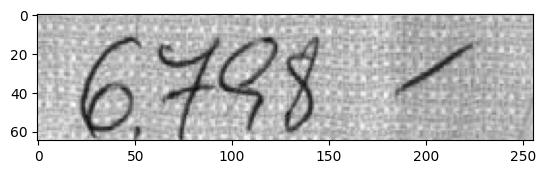

345


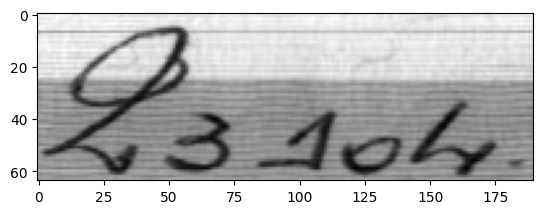

108


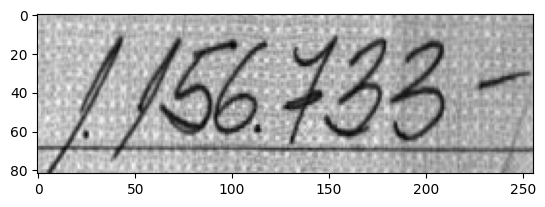

363


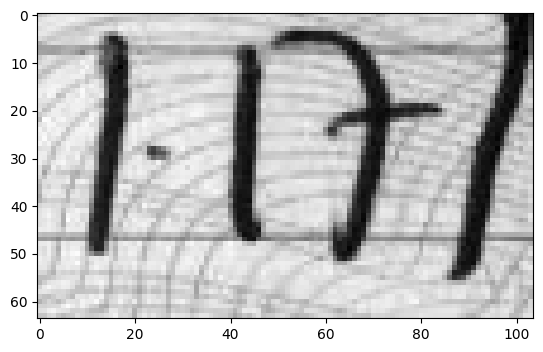

96


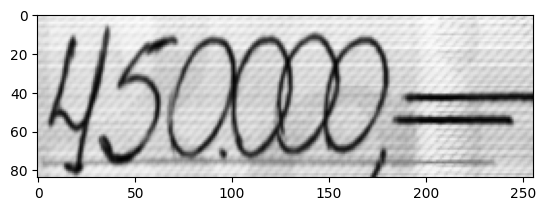

359


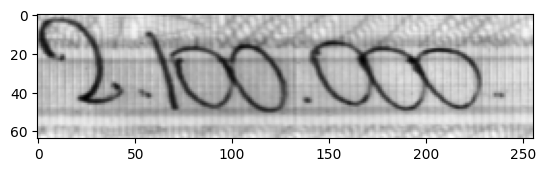

93


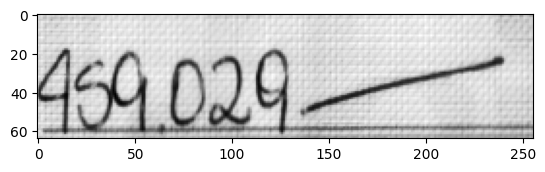

362


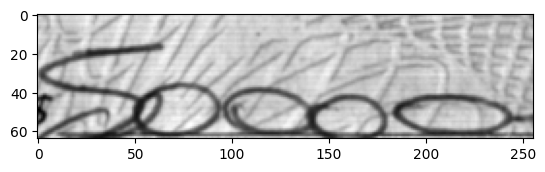

91
2009 3000 5009 5009


In [15]:
train_image_folder = 'ORAND-CAR-2014/ORAND-CAR-2014/CAR-A/a_train_images'
train_image_gt = "ORAND-CAR-2014/ORAND-CAR-2014/CAR-A/a_train_gt.txt"
val_image_folder = 'ORAND-CAR-2014/ORAND-CAR-2014/CAR-A/a_test_images'
val_image_gt = "ORAND-CAR-2014/ORAND-CAR-2014/CAR-A/a_test_gt.txt"

train_image_folder2 = 'ORAND-CAR-2014/ORAND-CAR-2014/CAR-B/b_train_images'
train_image_gt2 = "ORAND-CAR-2014/ORAND-CAR-2014/CAR-B/b_train_gt.txt"
test_image_folder = 'ORAND-CAR-2014/ORAND-CAR-2014/CAR-B/b_test_images'
test_image_gt = "ORAND-CAR-2014/ORAND-CAR-2014/CAR-B/b_test_gt.txt"

train_images1, train_labels1 = read_labels(train_image_folder, train_image_gt)
val_images, val_labels = read_labels(val_image_folder, val_image_gt)

train_images2, train_labels2 = read_labels(train_image_folder2, train_image_gt2)
test_images, test_labels = read_labels(test_image_folder, test_image_gt)

train_images = np.concatenate([train_images1, train_images2])
train_labels = np.append(train_labels1, train_labels2)
print(len(train_images1), len(train_images2), len(train_images), len(train_labels))

train_size = len(train_images)
valid_size = len(val_images)
test_size = len(test_images)

# Preparing the labels for CTC Loss

In [16]:
alphabets = u"0123456789"
max_str_len = 8  # max length of input labels
num_of_characters = len(alphabets) + 1  # +1 for ctc pseudo blank(epsilon)
num_of_timestamps = 64  # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        #find() method returns the lowest index of the substring if it is found in given string otherwise -1

    return np.array(label_num)


def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret += alphabets[ch]
    return ret

In [17]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps - 2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train_labels[i])
    train_y[i, 0:len(train_labels[i])] = label_to_num(train_labels[i])

valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps - 2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(val_labels[i])
    valid_y[i, 0:len(val_labels[i])] = label_to_num(val_labels[i])

print('True label : ', train_labels[100], '\ntrain_y : ', train_y[100], '\ntrain_label_len : ', train_label_len[100],
      '\ntrain_input_len : ', train_input_len[100])

True label :  2200 
train_y :  [ 2.  2.  0.  0. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


# Build the model (Multiple option choose one and run)
Chatgpt model (problem: low Accuracy, loss:10)

In [18]:
input_shape = (256, 64, 1)
input_data = Input(shape=input_shape, name='input')

inner = Conv2D(32, (3, 3), activation='relu', padding='same')(input_data)
inner = MaxPooling2D((2, 2))(inner)
inner = Conv2D(64, (3, 3), activation='relu', padding='same')(inner)
inner = MaxPooling2D((2, 2))(inner)
inner = Conv2D(128, (3, 3), activation='relu', padding='same')(inner)
inner = MaxPooling2D((2, 2))(inner)
inner = Conv2D(256, (3, 3), activation='relu', padding='same')(inner)
inner = MaxPooling2D((2, 2))(inner)
inner = Reshape((-1, inner.shape[-1]))(inner)

## RNN
inner = Bidirectional(layers.LSTM(128, return_sequences=True))(inner)
inner = Bidirectional(layers.LSTM(128, return_sequences=True))(inner)
inner = layers.Dropout(0.5)(inner)
## OUTPUT
y_pred = Dense(num_of_characters, activation='softmax')(inner)

model = Model(input_data, y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 64, 32)       320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 128, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 32, 64)       18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 16, 128)       73856 

Zhan, H., Wang, Q., Lu, Y., "Handwritten digit string recognition by combination of residual network and RNN-CTC" 2017 (problem: too much proccess & too slow)

In [19]:
input_shape = (256, 64, 1)
input_data = Input(shape=input_shape, name='input')

x = layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu')(input_data)
x = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)

# Block 1
x1 = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x2 = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x2 = layers.UpSampling2D((2, 2))(x2)  # Upsample to match the shape of x1
x = layers.add([x1, x2])

# Block 2
x1 = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x2 = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x2 = layers.UpSampling2D((2, 2))(x2)  # Upsample to match the shape of x1
x = layers.add([x1, x2])

# Block 3
x1 = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x2 = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x2 = layers.UpSampling2D((2, 2))(x2)  # Upsample to match the shape of x1
x = layers.add([x1, x2])

# Block 4
x1 = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x2 = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x2 = layers.UpSampling2D((2, 2))(x2)  # Upsample to match the shape of x1
x = layers.add([x1, x2])

# Block 5
x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)

# Permute the blob to fit LSTM
x = layers.Permute((2, 1, 3))(x)
shape = x.shape
x = layers.Reshape(target_shape=(shape[1], shape[2] * shape[3]))(x)

# Reverse layer
x = layers.Lambda(lambda t: tf.reverse(t, axis=[1]))(x)

# LSTM layers
x = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(x)

# Reverse layer
x = layers.Lambda(lambda t: tf.reverse(t, axis=[1]))(x)
x = layers.Dense(100, activation='relu')(x)
y_pred = layers.Dense(11, activation='softmax')(x)

model = Model(input_data, y_pred)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 256, 64, 1)]         0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 256, 64, 64)          1664      ['input[0][0]']               
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 256, 64, 64)          0         ['conv2d_6[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 128, 32, 64)          36928     ['max_pooling2d_6[0][0]'

Shi, B., Bai, X., & Yao, C., "An End-to-End Trainable Neural Network for Image-Based Sequence Recognition and Its Application to Scene Text Recognition" 2017

In [20]:
input_shape = (256, 64, 1)
input_data = Input(shape=input_shape, name='input')
# Convolutional layers
x = Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same')(input_data)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((1, 2), padding='same')(x)
x = Conv2D(512, (2, 2), activation='relu', padding='same')(x)

# Map to sequence
x = Reshape((-1, 512))(x)

# Recurrent layers
x = Bidirectional(LSTM(256, return_sequences=True))(x)
x = Bidirectional(LSTM(256, return_sequences=True))(x)

# Output layer
y_pred = Dense(num_of_characters, activation='softmax')(x)

model = Model(input_data, y_pred)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 256, 64, 64)       640       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 128, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 32, 128)      73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 64, 16, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 16, 256)       2951


Sagar-modelling / Handwriting_Recognition_CRNN_LSTM

In [21]:
input_shape = (256, 64, 1)
input_data = Input(shape=input_shape, name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(input_data, y_pred)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization_2 (Bat  (None, 256, 64, 32)       128       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                           

# the ctc loss function

In [22]:
# def scheduler(epoch, lr):
#     if epoch < 50:
#         return lr
#     else:
#         return 0.01

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

file_path_best = "RNN_model.keras"
op = Adam()  # ---------------------------------------------------------------------------------------------
# lr_cb = LearningRateScheduler(scheduler)
ls = {'ctc': lambda y_true, y_pred: y_pred}
model_final.compile(loss=ls, optimizer=op)

checkpoint = ModelCheckpoint(filepath=file_path_best,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

earlystop = EarlyStopping(monitor='val_loss',
                          patience=10
                          )

callbacks_list = [earlystop, checkpoint]


# Training model and plotting the train and validation state loss in each epoch

Epoch 1/40
79/79 [==============================] - ETA: 0s - loss: 0.1190
Epoch 1: val_loss did not improve from 0.69586
79/79 [==============================] - 71s 898ms/step - loss: 0.1190 - val_loss: 0.6967
Epoch 2/40
79/79 [==============================] - ETA: 0s - loss: 0.1229
Epoch 2: val_loss did not improve from 0.69586
79/79 [==============================] - 71s 898ms/step - loss: 0.1229 - val_loss: 0.7599
Epoch 3/40
79/79 [==============================] - ETA: 0s - loss: 0.1249
Epoch 3: val_loss did not improve from 0.69586
79/79 [==============================] - 71s 902ms/step - loss: 0.1249 - val_loss: 0.8418
Epoch 4/40
79/79 [==============================] - ETA: 0s - loss: 0.0831
Epoch 4: val_loss did not improve from 0.69586
79/79 [==============================] - 71s 899ms/step - loss: 0.0831 - val_loss: 0.7229
Epoch 5/40
79/79 [==============================] - ETA: 0s - loss: 0.0976
Epoch 5: val_loss did not improve from 0.69586
79/79 [=======================

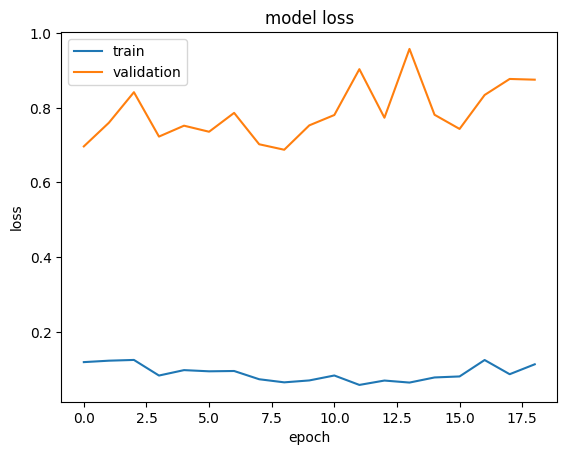

In [24]:
history = model_final.fit(x=[train_images, train_y, train_input_len, train_label_len],
                          y=train_output,
                          validation_data=([val_images, valid_y, valid_input_len, valid_label_len], valid_output),
                          callbacks=callbacks_list,
                          verbose=1,
                          epochs=40,
                          batch_size=64,
                          shuffle=True)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
model.load_weights('RNN_model.keras')
preds = model.predict(test_images)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0]) * preds.shape[1],
                                   greedy=True)[0][0])

prediction = []
for i in range(test_size):
    prediction.append(num_to_label(decoded[i]))

y_true = test_labels
sim = 0
total_char = 0
equality = 0

for i in range(test_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    similarity = difflib.SequenceMatcher(None, pr, tr).ratio()
    sim += similarity

    if (pr == tr):
        equality += 1

print('Similarity accuracy:  %.2f%%' % (sim * 100 / test_size))
print('Equality accuracy  :  %.2f%%' % (equality * 100 / test_size))

92/92 [==============================] - 14s 137ms/step
Similarity accuracy:  97.68%
Equality accuracy  :  87.97%


# How difflib.SequenceMatcher works

In [12]:
str1 = "kitten"
str2 = "sitting"

similarity = difflib.SequenceMatcher(None, str1, str2).ratio()

print("similarity: ", similarity)

similarity:  0.6153846153846154
